# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
# Import the class
from xopt import Xopt

# Notebook printing output
#from xopt import output_notebook
#output_notebook()

import multiprocessing
N_CPUS=multiprocessing.cpu_count()//2
N_CPUS



1

In [2]:
!mkdir -p temp

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """
xopt:
  asynch: True
  max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt
________________________________
Version: 0+untagged.1.g6b21941
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [4]:
%%timeit
# Check that the averate time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep = .1)

105 ms ± 9.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%time
X.run()

CPU times: user 7.8 s, sys: 24.9 ms, total: 7.82 s
Wall time: 1min 47s


# Processes

In [6]:
from concurrent.futures import ProcessPoolExecutor

In [7]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    
len(X.data)

CPU times: user 6.47 ms, sys: 0 ns, total: 6.47 ms
Wall time: 6.26 ms


0

# Threads

Continue running, this time with threads.

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
%%time

X = Xopt(YAML)

with ThreadPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 8 s, sys: 56.8 ms, total: 8.05 s
Wall time: 1min 48s


1000

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [10]:
X = Xopt(YAML)
X.yaml('test.yaml')
!cat test.yaml

xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [11]:
%%time
!mpirun -n {N_CPUS} python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2)
Parallel execution with 1 workers
Initializing Xopt object
Initializing generator cnsga,
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2
Initializing Xopt object
Xopt object initialized
Enabling async mode

            Xopt
________________________________
Version: 0+untagged.1.g6b21941
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  const

In [12]:
!tail xopt.log

2022-07-02T03:55:02+0000 - xopt.base - INFO - Running Xopt step
2022-07-02T03:55:02+0000 - xopt.base - INFO - Running Xopt step
2022-07-02T03:55:02+0000 - xopt.base - INFO - Running Xopt step
2022-07-02T03:55:02+0000 - xopt.base - INFO - Running Xopt step
2022-07-02T03:55:02+0000 - xopt.base - INFO - Running Xopt step
2022-07-02T03:55:02+0000 - xopt.base - INFO - Running Xopt step
2022-07-02T03:55:02+0000 - xopt.base - INFO - Running Xopt step
2022-07-02T03:55:03+0000 - xopt.base - INFO - Running Xopt step
2022-07-02T03:55:03+0000 - xopt.base - INFO - Running Xopt step
2022-07-02T03:55:03+0000 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [13]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 6.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46333,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 6.78 GiB
Comm: tcp://127.0.0.1:37135,Total threads: 1
Dashboard: http://127.0.0.1:36131/status,Memory: 3.39 GiB
Nanny: tcp://127.0.0.1:40631,


In [14]:
%%time
X = Xopt(YAML)
X.evaluator.executor = executor
X.evaluator.max_workers = N_CPUS
X.run()

CPU times: user 15.5 s, sys: 1.1 s, total: 16.6 s
Wall time: 1min 59s


# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [15]:
import pandas as pd

In [16]:
X.data

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
1,1.808780,1.367763,dummy_constant,1.808780,1.808780,1.367763,4.201896,2.465918,"[1, 2, 3]",False,
2,2.120526,1.915494,dummy_constant,2.120526,2.120526,1.915494,7.096949,4.629726,"[1, 2, 3]",False,
3,0.232819,2.029895,dummy_constant,0.232819,0.232819,2.029895,3.200034,2.411965,"[1, 2, 3]",False,
4,2.124857,0.742211,dummy_constant,2.124857,2.124857,0.742211,4.004233,2.698825,"[1, 2, 3]",False,
5,2.141356,3.067615,dummy_constant,2.141356,2.141356,3.067615,13.090405,9.286698,"[1, 2, 3]",False,
...,...,...,...,...,...,...,...,...,...,...,...
996,0.693730,0.772715,dummy_constant,NaN,0.693730,0.772715,0.013178,0.111905,"[1, 2, 3]",False,
997,0.805829,0.189202,dummy_constant,NaN,0.805829,0.189202,-0.229498,0.190127,"[1, 2, 3]",False,
998,0.995416,0.527025,dummy_constant,NaN,0.995416,0.527025,0.262303,0.246167,"[1, 2, 3]",False,
999,0.192060,0.939821,dummy_constant,NaN,0.192060,0.939821,0.019801,0.288270,"[1, 2, 3]",False,


In [17]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df['feasible']]

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str,feasible_c1,feasible_c2,feasible
12,0.591035,0.780655,dummy_constant,0.591035,0.591035,0.780655,0.017423,0.087055,"[1, 2, 3]",False,,True,True,True
18,0.251775,0.964980,dummy_constant,0.251775,0.251775,0.964980,0.053397,0.277822,"[1, 2, 3]",False,,True,True,True
38,0.751113,0.899920,dummy_constant,0.751113,0.751113,0.899920,0.360804,0.222994,"[1, 2, 3]",False,,True,True,True
41,0.887248,0.986797,dummy_constant,0.887248,0.887248,0.986797,0.694913,0.386932,"[1, 2, 3]",False,,True,True,True
44,1.155587,0.522470,dummy_constant,1.155587,1.155587,0.522470,0.521118,0.430299,"[1, 2, 3]",False,,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,0.849505,0.752212,dummy_constant,NaN,0.849505,0.752212,0.231009,0.185765,"[1, 2, 3]",False,,True,True,True
996,0.693730,0.772715,dummy_constant,NaN,0.693730,0.772715,0.013178,0.111905,"[1, 2, 3]",False,,True,True,True
998,0.995416,0.527025,dummy_constant,NaN,0.995416,0.527025,0.262303,0.246167,"[1, 2, 3]",False,,True,True,True
999,0.192060,0.939821,dummy_constant,NaN,0.192060,0.939821,0.019801,0.288270,"[1, 2, 3]",False,,True,True,True


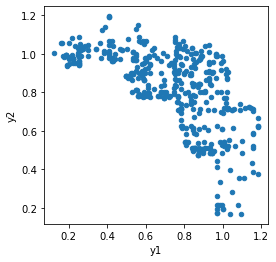

In [18]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

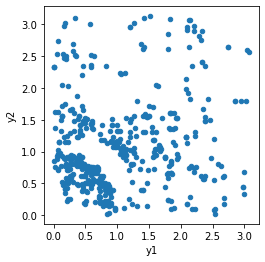

In [19]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

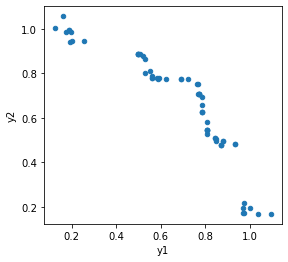

In [20]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

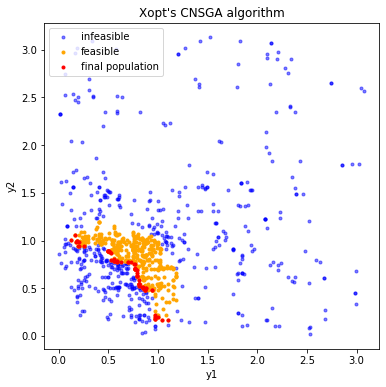

In [22]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title(f"Xopt's CNSGA algorithm")
plt.legend()

In [23]:
# Cleanup
!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.yaml